In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
import numpy as np
import open3d as o3d
import torch
from skimage import measure
from tqdm import tqdm, trange

from core.dataset import ScanNet
from core.integrate import FeatureFusionScalableTSDFVolume, ScalableTSDFVolume
# from core.integrate.utils import discrete2hash, discrete2world, discretize_3d, hash2discrete
# from temp import build_depth_from_voxel, pixel_dense_voxel_projection

In [7]:
tsdf_device = 'cuda:1'
tsdf_volume = FeatureFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)

save_dir = '/home/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/'
# tsdf_volume.load(save_dir + 'tsdf/tsdf_vol.pt')

In [8]:
# voxel_coord = discrete2world(
#     hash2discrete(tsdf_volume._voxel_hash),
#     voxel_size=tsdf_volume._voxel_size,
#     voxel_origin=tsdf_volume._vol_origin,
# ).cpu().numpy()

In [9]:
# pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(voxel_coord))
# voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(
#     input=pcd,
#     voxel_size=tsdf_volume._voxel_size,
# )

In [10]:
dataset = ScanNet('/home/quanta/Datasets/ScanNet/')
scan_id = 'scene0000_00'
id = dataset.scan_id_list.index(scan_id)
inst = dataset[id]
single_instance = inst['scan_dataset']

In [11]:
H, W = inst['color_height'], inst['color_width']
# intr = inst['intrinsic_color_matrix']

# fx, fy = intr[0, 0], intr[1, 1]
# cx, cy = intr[0, 2], intr[1, 2]

In [12]:
verts = np.load(save_dir + 'tsdf/verts.npy')
faces = np.load(save_dir + 'tsdf/faces.npy')

# mesh = o3d.geometry.TriangleMesh(
#     vertices=o3d.utility.Vector3dVector(verts),
#     triangles=o3d.utility.Vector3iVector(faces),
# )

In [9]:
# mat = o3d.visualization.rendering.MaterialRecord()
# # mat.shader = "defaultUnlit"

# renderer = o3d.visualization.rendering.OffscreenRenderer(
#     height=H,
#     width=W,
# )
# renderer.scene.set_background(np.array([0, 0, 0, 0]))
# # renderer.scene.add_geometry("voxel", voxel, mat)
# # renderer.scene.add_geometry("voxel", pcd, mat)
# renderer.scene.add_geometry("voxel", mesh, mat)


In [14]:
indent = 1
# for idx in trange(0, len(single_instance), indent):
for idx in trange(1):
    idx = 1024
    inputs = single_instance.get_torch_tensor(
        idx,
        device=tsdf_device,
        keys={
            "depth",
            "depth_intr",
            "pose",
            "color_intr",
            "color",
        },
    )

    # renderer.setup_camera(
    #     inputs['color_intr'][:3, :3].cpu().numpy(),
    #     inputs['pose'].cpu().numpy(),
    #     0,0,
    # )

    

100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


In [15]:
# mesh = o3d.cuda.pybind.t.geometry.TriangleMesh(verts.astype(np.float32), faces)
mesh = o3d.t.geometry.TriangleMesh(verts.astype(np.float32), faces)

In [24]:
# help(o3d.cuda.pybind.t.geometry.TriangleMesh)

In [16]:
a = o3d.t.geometry.RaycastingScene()
a.add_triangles(mesh)

0

In [26]:
# help(a.create_rays_pinhole)

In [36]:


# keys={
#             "depth",
#             "depth_intr",
#             "pose",
#             "color_intr",
#             "color",
#         # },

In [ ]:
# help(o3d.core.Tensor)

In [17]:
# help(a)
# a.cast_rays(rays)

idx = 4650
inputs = single_instance.get_torch_tensor(
    idx,
    device=tsdf_device,
    keys={
        "depth",
        "depth_intr",
        "pose",
        "color_intr",
        "color",
    },
)

In [18]:
%%time
rays = a.create_rays_pinhole(
    intrinsic_matrix=o3d.core.Tensor(inputs["color_intr"][:3, :3].cpu().numpy()),
    extrinsic_matrix=o3d.core.Tensor(np.linalg.inv(inputs["pose"].cpu().numpy())),
    width_px=W,
    height_px=H,
)
anw = a.cast_rays(rays)

CPU times: user 4.56 s, sys: 185 ms, total: 4.75 s
Wall time: 181 ms


In [19]:
anw.keys()

dict_keys(['primitive_uvs', 'primitive_ids', 'geometry_ids', 'primitive_normals', 't_hit'])

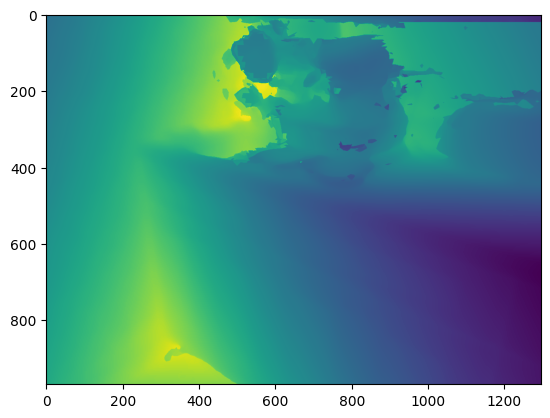

In [20]:
import matplotlib.pyplot as plt

plt.imshow(anw['t_hit'].numpy())

In [63]:
help(o3d.t.geometry.VoxelBlockGrid)

Help on class VoxelBlockGrid in module open3d.cuda.pybind.t.geometry:

class VoxelBlockGrid(pybind11_builtins.pybind11_object)
 |  A voxel block grid is a sparse grid of voxel blocks. Each voxel block is a dense 3D array, preserving local data distribution. If the block_resolution is set to 1, then the VoxelBlockGrid degenerates to a sparse voxel grid.
 |  
 |  Method resolution order:
 |      VoxelBlockGrid
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: open3d.cuda.pybind.t.geometry.VoxelBlockGrid, attr_names: List[str], attr_dtypes: List[open3d.cuda.pybind.core.Dtype], attr_channels: List[open3d.cuda.pybind.core.SizeVector], voxel_size: float = 0.0058, block_resolution: int = 16, block_count: int = 10000, device: open3d.cuda.pybind.core.Device = CPU:0) -> None
 |  
 |  attribute(...)
 |      attribute(self: open3d.cuda.pybind.t.geometry.VoxelBlockGrid, attribute_name: str) -> open3d.cuda.p

In [64]:
# voxel_grid_block have extract mesh method, but we can not import existing voxel to it

In [ ]:
# todo voxel to meshes! not marching cube, 
# be careful with the ordering!